# WMH Segmentation Baseline Experiment

This notebook implements a baseline 3D U-Net model using nnU-Net framework for WMH segmentation.

## Setup and Dependencies

In [ ]:
!pip install --upgrade pip
!pip install nnunet torch monai nibabel numpy scipy scikit-learn matplotlib

In [1]:
import os
import numpy as np
import json
import torch
from pathlib import Path
import nibabel as nib
from monai.metrics import DiceMetric
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,  # Changed from AddChanneld
    ScaleIntensityd,
    RandFlipd,
    RandRotate90d,
    RandShiftIntensityd,
    ToTensord
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss

## Data Loading and Preparation

Load the preprocessed WMH dataset and prepare for training

In [2]:
def get_data_dicts(data_root):
    data_dicts = []
    for subject_dir in Path(data_root).glob('**/pre2'):
        if subject_dir.is_dir():
            data_dict = {
                'flair': str(subject_dir / 'FLAIR.nii.gz'),
                't1': str(subject_dir / 'T1.nii.gz'),
                'label': str(subject_dir.parent / 'wmh.nii.gz')
            }
            # check if the label file dimension is the same as the flair and t1 file
            label_shape = nib.load(data_dict['label']).get_fdata().shape
            flair_shape = nib.load(data_dict['flair']).get_fdata().shape
            t1_shape = nib.load(data_dict['t1']).get_fdata().shape
            if label_shape == flair_shape == t1_shape:
                data_dicts.append(data_dict)
    return data_dicts

# Set data root and get data dictionaries
DATA_ROOT = Path('/Users/hsuh/Gitrepo/SwitchSite/1.data/MICCAI-2017')
data_dicts = get_data_dicts(DATA_ROOT)

# Split into train/val (80/20)
np.random.shuffle(data_dicts)
n_train = int(0.8 * len(data_dicts))
train_dicts = data_dicts[:n_train]
val_dicts = data_dicts[n_train:]

In [3]:
print(f"Found {len(data_dicts)} subjects")
print(f"Training on {len(train_dicts)} subjects, validating on {len(val_dicts)} subjects")

Found 100 subjects
Training on 80 subjects, validating on 20 subjects


In [4]:
import nibabel as nib

def print_data_sizes(data_dicts):
    print("Checking image sizes:")
    for d in data_dicts[:5]:  # Check first 5 samples
        flair = nib.load(d['flair'])
        t1 = nib.load(d['t1'])
        label = nib.load(d['label'])
        print(f"FLAIR: {flair.shape}, T1: {t1.shape}, Label: {label.shape}")

print_data_sizes(train_dicts)

Checking image sizes:
FLAIR: (240, 240, 48), T1: (240, 240, 48), Label: (240, 240, 48)
FLAIR: (240, 240, 48), T1: (240, 240, 48), Label: (240, 240, 48)
FLAIR: (240, 240, 48), T1: (240, 240, 48), Label: (240, 240, 48)
FLAIR: (232, 256, 48), T1: (232, 256, 48), Label: (232, 256, 48)
FLAIR: (232, 256, 48), T1: (232, 256, 48), Label: (232, 256, 48)


## Define Model and Training Functions

In [5]:
def create_model():
    return UNet(
        spatial_dims=3,
        in_channels=2,  # FLAIR + T1
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2
    )

def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs = torch.cat([
            batch_data['flair'],
            batch_data['t1']
        ], dim=1).to(device)
        labels = batch_data['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [6]:
def validate_loss(model, val_loader, loss_function, device):
    model.eval()
    val_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch_data in val_loader:
            inputs = torch.cat([
                batch_data['flair'],
                batch_data['t1']
            ], dim=1).to(device)
            labels = batch_data['label'].to(device)
            
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            num_batches += 1
            
    return val_loss / num_batches

def validate(model, val_loader, metric, device):
    model.eval()
    metric.reset()
    
    with torch.no_grad():
        for batch_data in val_loader:
            inputs = torch.cat([
                batch_data['flair'],
                batch_data['t1']
            ], dim=1).to(device)
            labels = batch_data['label'].to(device)
            
            outputs = model(inputs)
            
            # # Debug prints to check shapes and values
            # print(f"Output shape: {outputs.shape}")
            # print(f"Output min/max: {outputs.min().item():.4f}, {outputs.max().item():.4f}")
            # print(f"Label shape: {labels.shape}")
            # print(f"Label unique values: {torch.unique(labels)}")
            
            # Convert outputs to predictions
            preds = (outputs > 0.5).float()
            
            # # Debug prints for predictions
            # print(f"Prediction unique values: {torch.unique(preds)}")
            
            # Compute metric
            metric(y_pred=preds, y=labels)
            
    # Get the metric value
    metric_value = metric.aggregate()
    # print(f"Raw metric value: {metric_value}")
    
    # Reset the metric for next validation
    metric.reset()
    
    return metric_value

In [7]:
spatial_size = (240, 240, 48) 

In [8]:

# Modified transforms with spatial resizing
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd,
    RandFlipd,
    RandRotate90d,
    RandShiftIntensityd,
    ToTensord,
    Spacingd,
    Resized,
    MapLabelValueD
)

train_transforms = Compose([
    LoadImaged(keys=['flair', 't1', 'label']),
    EnsureChannelFirstd(keys=['flair', 't1', 'label']),
    Spacingd(
        keys=['flair', 't1', 'label'],
        pixdim=(1.0, 1.0, 1.0),
        mode=('bilinear', 'bilinear', 'nearest')
    ),
    Resized(
        keys=['flair', 't1', 'label'],
        spatial_size=spatial_size,
        mode=('trilinear', 'trilinear', 'nearest')
    ),
    # Convert labels: 0->0 (background), 1->1 (WMH), 2->0 (ignore other pathology)
    MapLabelValueD(
        keys=['label'],
        orig_labels=[0, 1, 2],
        target_labels=[0, 1, 0]
    ),
    ScaleIntensityd(keys=['flair', 't1']),
    RandFlipd(keys=['flair', 't1', 'label'], prob=0.5, spatial_axis=0),
    RandRotate90d(keys=['flair', 't1', 'label'], prob=0.5, spatial_axes=[0, 1]),
    RandShiftIntensityd(keys=['flair', 't1'], offsets=0.1, prob=0.5),
    ToTensord(keys=['flair', 't1', 'label'])
])

val_transforms = Compose([
    LoadImaged(keys=['flair', 't1', 'label']),
    EnsureChannelFirstd(keys=['flair', 't1', 'label']),
    Spacingd(
        keys=['flair', 't1', 'label'],
        pixdim=(1.0, 1.0, 1.0),
        mode=('bilinear', 'bilinear', 'nearest')
    ),
    Resized(
        keys=['flair', 't1', 'label'],
        spatial_size=spatial_size,
        mode=('trilinear', 'trilinear', 'nearest')
    ),
    # Convert labels: 0->0 (background), 1->1 (WMH), 2->0 (ignore other pathology)
    MapLabelValueD(
        keys=['label'],
        orig_labels=[0, 1, 2],
        target_labels=[0, 1, 0]
    ),
    ScaleIntensityd(keys=['flair', 't1']),
    ToTensord(keys=['flair', 't1', 'label'])
])


In [9]:
# Create datasets with cache
from monai.data import CacheDataset

train_ds = CacheDataset(
    data=train_dicts,
    transform=train_transforms,
    cache_rate=1.0,
    num_workers=4
)

val_ds = CacheDataset(
    data=val_dicts,
    transform=val_transforms,
    cache_rate=1.0,
    num_workers=4
)


Loading dataset: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


In [10]:
# Create data loaders with smaller batch size initially
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=2,  # Reduced number of workers
    pin_memory=torch.cuda.is_available()
)

## Training Loop

In [ ]:
# Add this check to your data loading code
def check_data_shapes(data_dicts):
    for d in data_dicts[:5]:  # Check first 5 samples
        print(f"Checking data for {d['flair']}")
        flair = nib.load(d['flair'])
        t1 = nib.load(d['t1'])
        label = nib.load(d['label'])
        print(f"FLAIR shape: {flair.shape}")
        print(f"T1 shape: {t1.shape}")
        print(f"Label shape: {label.shape}")
        print(f"Label unique values: {np.unique(label.get_fdata())}")
        print("---")

check_data_shapes(train_dicts)

In [11]:
# Training configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model().to(device)
loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_metric = DiceMetric(
    include_background=False,
    reduction="mean",
    get_not_nans=False
)

In [62]:
# Training loop
num_epochs = 1
best_metric = -1
best_metric_epoch = -1

history = {
    'training_loss': [],
    'validation_loss': [],
    'validation_dice': []
}

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    print(f'Training loss: {train_loss:.4f}')
    history['training_loss'].append(train_loss)
    
    # Validate
    val_loss = validate_loss(model, val_loader, loss_function, device)
    print(f'Validation loss: {val_loss:.4f}')
    history['validation_loss'].append(val_loss)

    val_metric_tensor = validate(model, val_loader, dice_metric, device)
    val_metric = val_metric_tensor.item() if torch.is_tensor(val_metric_tensor) else float(val_metric_tensor)
    print(f'Validation Dice: {val_metric:.4f}')
    history['validation_dice'].append(val_metric)

    # Save best model
    if val_metric > best_metric:
        best_metric = val_metric
        best_metric_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')
        with open('history.json', 'w') as f:
            json.dump(history, f, indent=4)
        print('Saved new best model')

print(f'\nTraining completed. Best validation Dice: {best_metric:.4f} at epoch {best_metric_epoch}')


Epoch 1/1
Training loss: 0.9903
Validation loss: 0.9890
Validation Dice: 0.0875
Saved new best model

Training completed. Best validation Dice: 0.0875 at epoch 1


# Additional training

In [64]:
# Load the previously saved best model
model.load_state_dict(torch.load('best_model.pth'))
history = json.load(open('history.json'))

# Set additional training parameters
additional_epochs = 5  # Set how many more epochs you want to train
start_epoch = best_metric_epoch  # Continue counting from where we left off
current_best_metric = best_metric  # Keep track of our previous best metric

# Continue training loop
for epoch in range(additional_epochs):
    print(f'\nEpoch {start_epoch + epoch + 1}/{start_epoch + additional_epochs}')
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    print(f'Training loss: {train_loss:.4f}')
    history['training_loss'].append(train_loss)

    # Validate
    val_loss = validate_loss(model, val_loader, loss_function, device)
    print(f'Validation loss: {val_loss:.4f}')
    history['validation_loss'].append(val_loss)
    
    val_metric_tensor = validate(model, val_loader, dice_metric, device)
    val_metric = val_metric_tensor.item() if torch.is_tensor(val_metric_tensor) else float(val_metric_tensor)
    print(f'Validation Dice: {val_metric:.4f}')
    history['validation_dice'].append(val_metric)
    
    # Save model if we get better performance
    if val_metric > current_best_metric:
        current_best_metric = val_metric
        best_metric_epoch = start_epoch + epoch + 1
        torch.save(model.state_dict(), f'best_model_{best_metric_epoch}.pth')
        print('Saved new best model')
        with open('history.json', 'w') as f:
            json.dump(history, f, indent=4)

print(f'\nAdditional training completed. Best validation Dice: {current_best_metric:.4f} at epoch {best_metric_epoch}')


Epoch 2/6
Training loss: 0.9902
Validation loss: 0.9889
Validation Dice: 0.0766

Epoch 3/6
Training loss: 0.9901
Validation loss: 0.9888
Validation Dice: 0.0938
Saved new best model

Epoch 4/6
Training loss: 0.9900
Validation loss: 0.9886
Validation Dice: 0.0940
Saved new best model

Epoch 5/6
Training loss: 0.9899
Validation loss: 0.9885
Validation Dice: 0.0834

Epoch 6/6
Training loss: 0.9899
Validation loss: 0.9884
Validation Dice: 0.0956
Saved new best model

Additional training completed. Best validation Dice: 0.0956 at epoch 6


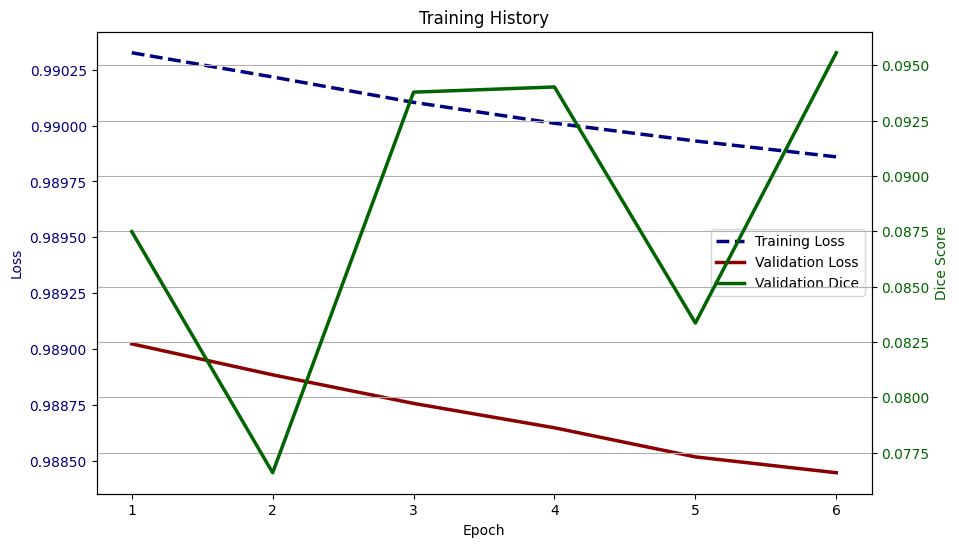

In [21]:
import matplotlib.pyplot as plt
import json

def plot_training_history(history: dict, save_path: str = None) -> None:
    """
    Create a plot showing training/validation metrics over epochs with two y-axes
    
    Args:
        history: Dictionary with 'training_loss', 'validation_loss', 'validation_dice'
        save_path: Optional path to save the plot
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))
    epochs = range(1, len(history['training_loss']) + 1)
    
    # Left y-axis for losses
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='#000080')  # Dark blue
    ln1 = ax1.plot(epochs, history['training_loss'], color='#000080', label='Training Loss', 
                   linestyle='--', linewidth=2.5)
    ln2 = ax1.plot(epochs, history['validation_loss'], color='#8B0000', label='Validation Loss',  # Dark red
                   linestyle='-', linewidth=2.5)
    ax1.tick_params(axis='y', labelcolor='#000080')
    
    # Right y-axis for Dice score
    ax2 = ax1.twinx()
    ax2.set_ylabel('Dice Score', color='#006400')  # Dark green
    ln3 = ax2.plot(epochs, history['validation_dice'], color='#006400', label='Validation Dice',
                   linestyle='-', linewidth=2.5)
    ax2.tick_params(axis='y', labelcolor='#006400')
    
    # Add all lines to legend
    lns = ln1 + ln2 + ln3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='center right')
    
    plt.title('Training History')
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Usage in notebook:
with open('history.json', 'r') as f:
    history = json.load(f)
    plot_training_history(history, 'training_history.png')

## Evaluation and Visualization

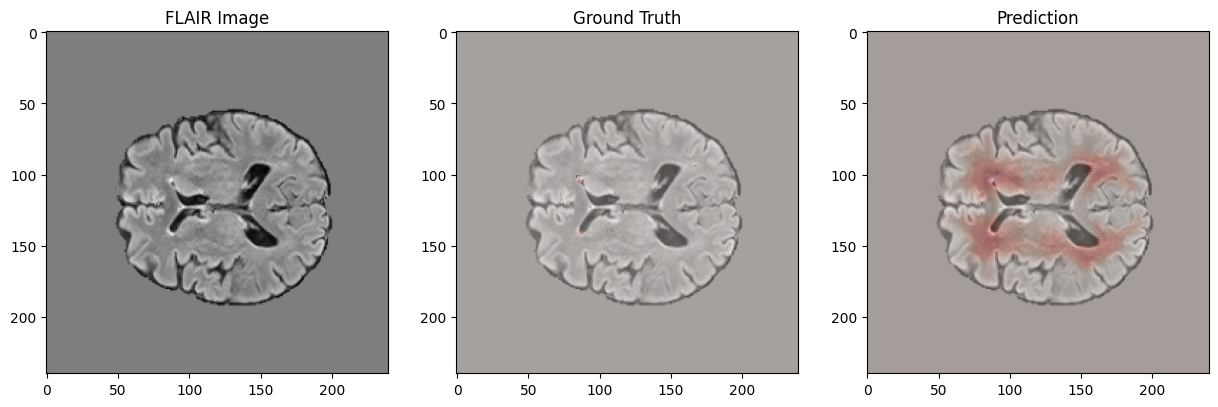

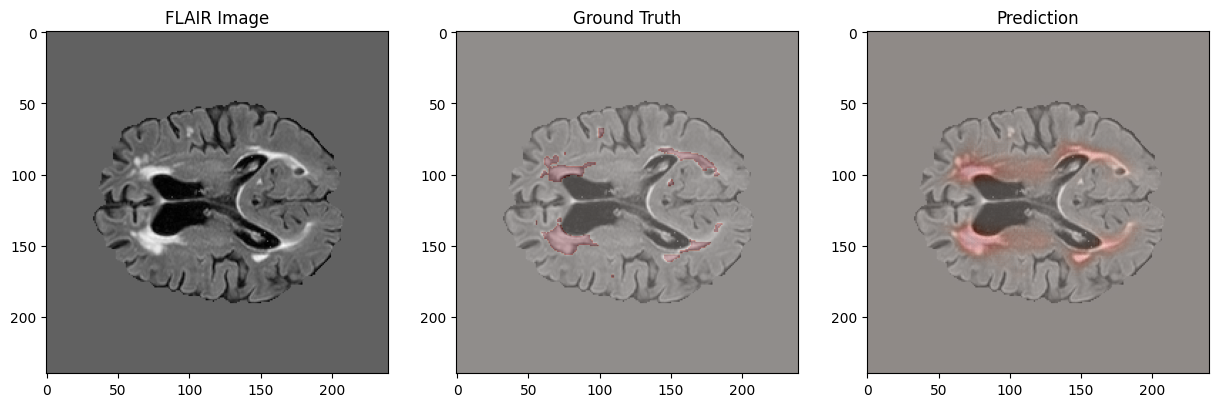

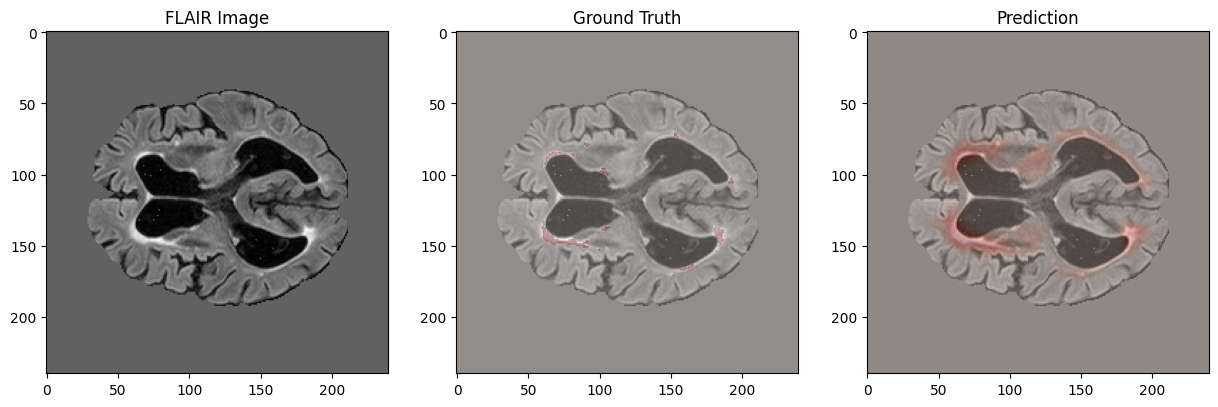

In [22]:
from matplotlib import pyplot as plt
from evaluation_metrics import evaluate_segmentation, evaluate_batch


def plot_results(image, truth, pred, slice_idx=None, save_path=None):
    if slice_idx is None:
        slice_idx = image.shape[2] // 2
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.imshow(image[:, :, slice_idx], cmap='gray')
    ax1.set_title('FLAIR Image')
    
    ax2.imshow(image[:, :, slice_idx], cmap='gray')
    ax2.imshow(truth[:, :, slice_idx], alpha=0.3, cmap='Reds')
    ax2.set_title('Ground Truth')
    
    ax3.imshow(image[:, :, slice_idx], cmap='gray')
    ax3.imshow(pred[:, :, slice_idx], alpha=0.3, cmap='Reds')
    ax3.set_title('Prediction')
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Load best model and evaluate on test cases
model.load_state_dict(torch.load('best_model_4.pth'))
model.eval()

with torch.no_grad():
    import random
    for i, val_data in enumerate(random.sample(list(val_loader), 5)):
    # for i, val_data in enumerate(val_loader):
        inputs = torch.cat([val_data['flair'], val_data['t1']], dim=1).to(device)
        # pred = model(inputs).sigmoid().cpu().numpy() > 0.5
        pred = model(inputs).cpu().numpy()
        
        # Plot results
        plot_results(
            val_data['flair'][0, 0].numpy(),
            val_data['label'][0, 0].numpy(),
            pred[0, 0],
            save_path=f'case_{i}.png'
        )
        
        # # For complete evaluation
        # metrics = evaluate_segmentation(val_data['label'][0, 0].numpy(), pred[0, 0])
        # print(f"Dice Similarity Coefficient (DSC): {metrics['dice']:.3f}")
        # print(f"Sensitivity: {metrics['sensitivity']:.3f}")
        # print(f"Specificity: {metrics['specificity']:.3f}")
        # print(f"Precision: {metrics['precision']:.3f}")
        # print(f"F1 Score: {metrics['f1_score']:.3f}")

        if i + 1 >= 3:  # Show first 3 cases
            break

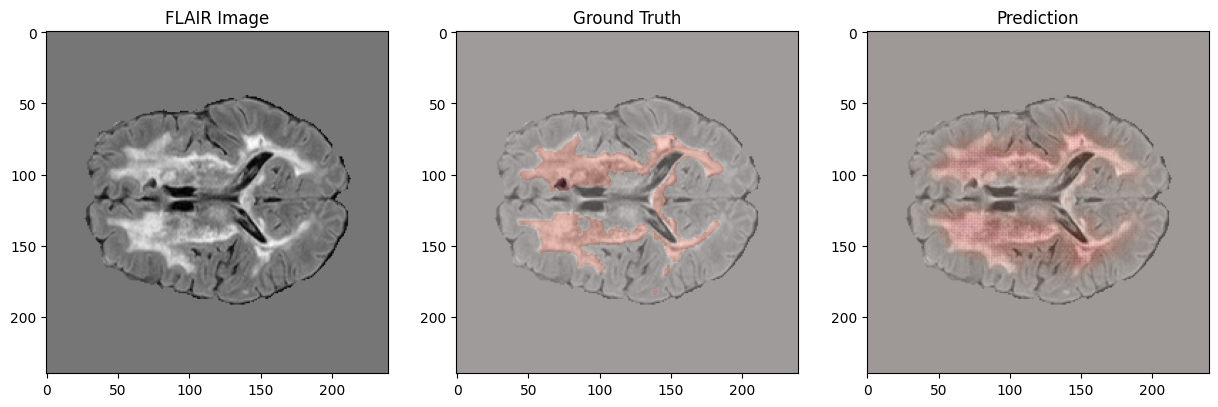

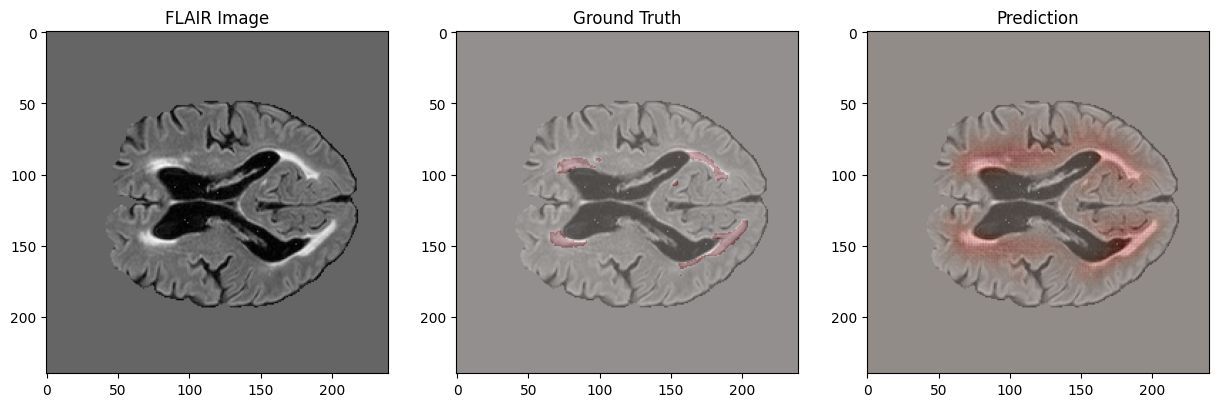

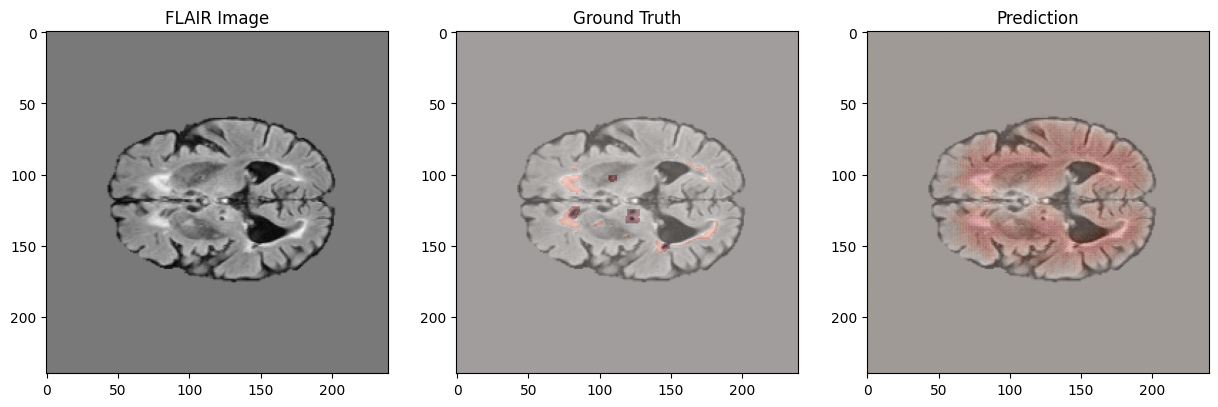

In [35]:
from matplotlib import pyplot as plt

def plot_results(image, truth, pred, slice_idx=None):
    if slice_idx is None:
        slice_idx = image.shape[2] // 2
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.imshow(image[:, :, slice_idx], cmap='gray')
    ax1.set_title('FLAIR Image')
    
    ax2.imshow(image[:, :, slice_idx], cmap='gray')
    ax2.imshow(truth[:, :, slice_idx], alpha=0.3, cmap='Reds')
    ax2.set_title('Ground Truth')
    
    ax3.imshow(image[:, :, slice_idx], cmap='gray')
    ax3.imshow(pred[:, :, slice_idx], alpha=0.3, cmap='Reds')
    ax3.set_title('Prediction')
    
    plt.show()

# Load best model and evaluate on test cases
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        inputs = torch.cat([val_data['flair'], val_data['t1']], dim=1).to(device)
        # pred = model(inputs).sigmoid().cpu().numpy() > 0.5
        pred = model(inputs).cpu().numpy()
        
        # Plot results
        plot_results(
            val_data['flair'][0, 0].numpy(),
            val_data['label'][0, 0].numpy(),
            pred[0, 0]
        )
        
        if i >= 2:  # Show first 3 cases
            break